#### Prepare SparkSession

In [55]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import desc, col
import pandas as pd

spark = SparkSession.builder \
    .master('local[*]') \
    .appName('RDD Exercise') \
    .getOrCreate()
    
spark

#### Read the data

In [2]:
sales_data = spark.read \
  .csv('vgsales.csv', header=True, inferSchema=True)

In [3]:
sales_data.rdd.getNumPartitions()

1

In [4]:
sales_data.limit(5).toPandas()

,Name,Platform,Year_of_Release,Genre,Publisher,NA_Sales,EU_Sales,JP_Sales,Other_Sales,Global_Sales,Critic_Score,Critic_Count,User_Score,User_Count,Developer,Rating
0,Wii Sports,Wii,2006,Sports,Nintendo,41.36,28.96,3.77,8.45,82.53,76.0,51.0,8,322.0,Nintendo,E
1,Super Mario Bros.,NES,1985,Platform,Nintendo,29.08,3.58,6.81,0.77,40.24,NaN,NaN,None,NaN,None,None
2,Mario Kart Wii,Wii,2008,Racing,Nintendo,15.68,12.76,3.79,3.29,35.52,82.0,73.0,8.3,709.0,Nintendo,E
3,Wii Sports Resort,Wii,2009,Sports,Nintendo,15.61,10.93,3.28,2.95,32.77,80.0,73.0,8,192.0,Nintendo,E
4,Pokemon Red/Pokemon Blue,GB,1996,Role-Playing,Nintendo,11.27,8.89,10.22,1.00,31.37,NaN,NaN,None,NaN,None,None


#### Save as parquet with partitioning by type of housing

In [5]:
sales_data.write.partitionBy('Platform').parquet('salesparquet')

#### Reload the data from parquet

In [6]:
sales_data = spark.read.parquet('salesparquet')

#### Repartition the data (e.g., use 10 partitions) - in this sample dataset not really worth doing, but definitely important when it comes to performance tuning in Spark

In [7]:
sales_data = sales_data.repartition(10).cache()

In [8]:
sales_data.rdd.getNumPartitions()

10

#### Take a short look at the data

In [14]:
sales_data.limit(5).toPandas()

,Rank,Name,Year,Genre,Publisher,NA_Sales,EU_Sales,JP_Sales,Other_Sales,Global_Sales,Platform
0,14565,Worms,2009,Strategy,Sony Computer Entertainment,0.00,0.02,0.00,0.01,0.03,PS3
1,14703,MechAssault: Phantom War,2006,Simulation,Majesco Entertainment,0.03,0.00,0.00,0.00,0.03,DS
2,3,Mario Kart Wii,2008,Racing,Nintendo,15.85,12.88,3.79,3.31,35.82,Wii
3,5105,Mini Ninjas,2009,Action,Eidos Interactive,0.17,0.17,0.00,0.04,0.37,Wii
4,1385,Far Cry 2,2008,Action,Ubisoft,0.43,0.70,0.01,0.27,1.40,PS3


#### What does the dataset's schema look like (based on Spark's schema inference)?

In [9]:
sales_data.printSchema()

root
 |-- Name: string (nullable = true)
 |-- Year_of_Release: string (nullable = true)
 |-- Genre: string (nullable = true)
 |-- Publisher: string (nullable = true)
 |-- NA_Sales: double (nullable = true)
 |-- EU_Sales: double (nullable = true)
 |-- JP_Sales: double (nullable = true)
 |-- Other_Sales: double (nullable = true)
 |-- Global_Sales: double (nullable = true)
 |-- Critic_Score: integer (nullable = true)
 |-- Critic_Count: integer (nullable = true)
 |-- User_Score: string (nullable = true)
 |-- User_Count: integer (nullable = true)
 |-- Developer: string (nullable = true)
 |-- Rating: string (nullable = true)
 |-- Platform: string (nullable = true)



#### Get summary statistics for your data

In [10]:
sales_data.describe().toPandas()

,summary,Name,Year_of_Release,Genre,Publisher,NA_Sales,EU_Sales,JP_Sales,Other_Sales,Global_Sales,Critic_Score,Critic_Count,User_Score,User_Count,Developer,Rating,Platform
0,count,16717,16719,16717,16719,16719,16719,16719,16719,16719,8137,8137,10015,7590,10096,9950,16719
1,mean,1942.0,2006.4873556231003,None,None,0.26333034272384664,0.1450248220587358,0.07760212931395424,0.047331778216400736,0.5335426759973656,68.96767850559173,26.360820941378886,7.12504611330699,162.22990777338603,2015.0,None,2600.0
2,stddev,NaN,5.878994768348372,None,None,0.8135138347516192,0.5032832960942157,0.30881808051463777,0.18670989698947893,1.5479351247177673,13.938164552843212,18.98049453458207,1.5000060936257982,561.2823262473771,NaN,None,0.0
3,min,Beyblade Burst,1980,Action,10TACLE Studios,0.0,0.0,0.0,0.0,0.01,13,3,0,4,10tacle Studios,AO,2600
4,max,¡Shin Chan Flipa en colores!,N/A,Strategy,responDESIGN,41.36,28.96,10.22,10.57,82.53,98,113,tbd,10665,zSlide,T,XOne


### Inspect Data grouped by interesting Columns

In [11]:
sales_data.createOrReplaceTempView('sales_data')

#### By Platform

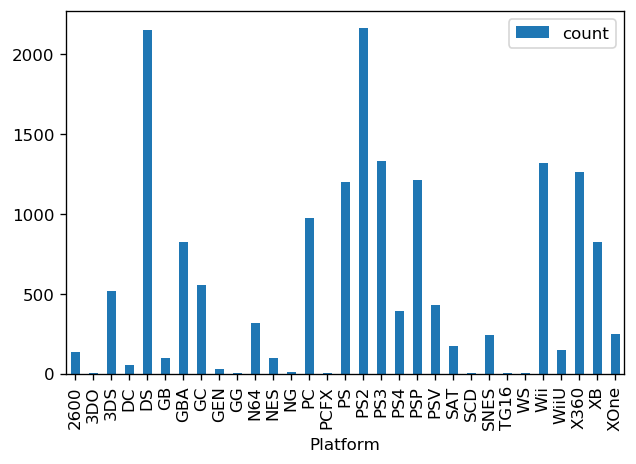

In [23]:
import matplotlib.pyplot as plt

# enable matplotlib inline to work with jupyter notebooks
%matplotlib inline

# increase plot size to be able to actually see something
plt.rcParams['figure.dpi'] = 120

sales_data.groupBy("Platform").count().sort('Platform').toPandas().plot.bar(x='Platform',y='count')

#### By Year

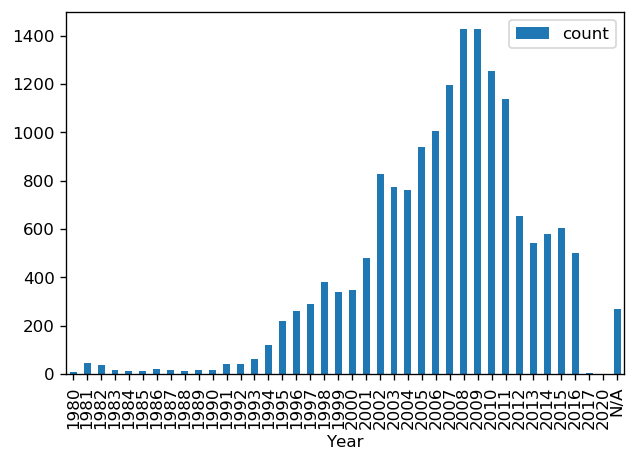

In [24]:
spark.sql('SELECT Year_of_Release as Year, COUNT(*) ' + \
          'AS count FROM sales_data ' + \
          'GROUP BY Year ' + \
          'ORDER BY Year') \
.toPandas().plot.bar(x='Year',y='count')

Games released in 2008 and 2009 have the highest sale count, this could be because of the release of the Nintendo Wii, lets take a look at this.

#### By Genre

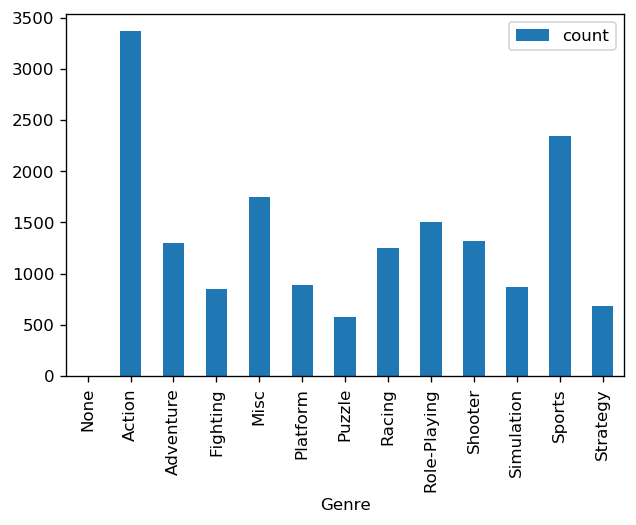

In [25]:
sales_data.groupBy("Genre").count().sort('Genre').toPandas().plot.bar(x='Genre',y='count')

The Action Genre is the most saled one, followed by the Sports Genre.

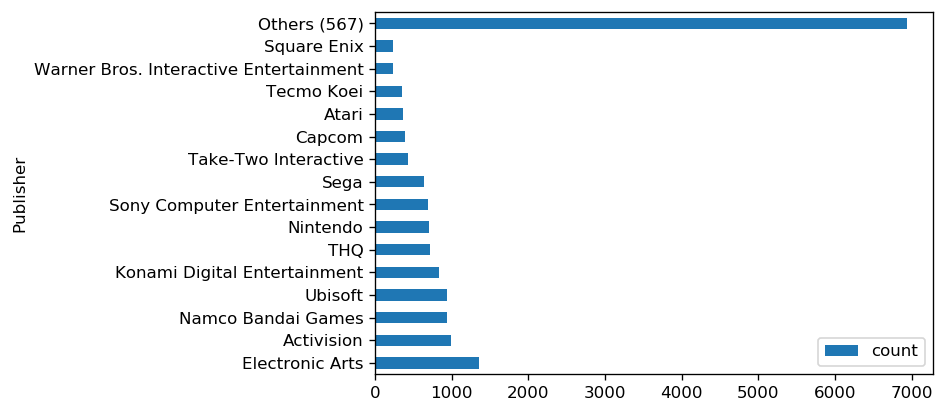

In [118]:
nr_publishers = sales_data.select("Publisher").distinct().count()
nr_top_publishers = 15

top_pubs = sales_data.groupBy("Publisher").count().sort(desc('count')).limit(nr_top_publishers).toPandas()

top_pubs_list = top_pubs["Publisher"].values.tolist()

# group remaining publishers, would be to many for a graph
top_pubs = top_pubs.append({
    "Publisher": "Others ({count})".format(count = str(nr_publishers - nr_top_publishers)),
     "count": sales_data.filter(~col("Publisher").isin(top_pubs_list)).count()
    }, ignore_index=True)

top_pubs.plot.barh(x = "Publisher", y = "count")

As the number of Publishers is high and the distribution of sales among them is not very outstanding, this features is among the less intersting ones.

## Select columns of interest

In [219]:
sales_data = sales_data[['Publisher', 'Platform',
                         'Genre', 'Critic_Score',
                         'User_Score', 'Global_Sales',
                         'Developer']]

In [220]:
sales_data = sales_data.filter(
    "CAST(User_Score AS DECIMAL) IS NOT NULL AND CAST(Critic_Score AS DECIMAL) IS NOT NULL"
)

## Regression based on the most impacting features

In [221]:
from pyspark.ml.feature import StringIndexer

indexer = StringIndexer(inputCol='Platform', outputCol='platform_index', handleInvalid="skip")
sales_data = indexer.fit(sales_data).transform(sales_data)

indexer = StringIndexer(inputCol='Genre', outputCol='genre_index', handleInvalid="skip")
sales_data = indexer.fit(sales_data).transform(sales_data)

indexer = StringIndexer(inputCol='Developer', outputCol='dev_index', handleInvalid="skip")
sales_data = indexer.fit(sales_data).transform(sales_data)

indexer = StringIndexer(inputCol='Publisher', outputCol='publisher_index', handleInvalid="skip")
sales_data = indexer.fit(sales_data).transform(sales_data)

sales_data.limit(10).toPandas()

,Publisher,Platform,Genre,Critic_Score,User_Score,Global_Sales,Developer,platform_index,genre_index,dev_index,publisher_index
0,Universal Interactive,PS2,Shooter,75,8.5,0.42,Terminal Reality,0.0,2.0,53.0,41.0
1,Nippon Ichi Software,PS2,Role-Playing,69,7.5,0.06,Gust,0.0,3.0,101.0,26.0
2,Activision,PS3,Action,77,6.3,1.06,Toys for Bob,2.0,0.0,83.0,2.0
3,Sega,Wii,Platform,54,6.9,1.09,Sonic Team,5.0,5.0,24.0,6.0
4,Majesco Entertainment,DS,Platform,79,8,0.06,DreamRift,6.0,5.0,911.0,37.0
5,Sega,Wii,Fighting,58,7.5,0.32,Polygon Magic,5.0,7.0,425.0,6.0
6,SouthPeak Games,DS,Action,45,7.3,0.11,Red Fly Studio,6.0,0.0,245.0,38.0
7,Namco Bandai Games,PS3,Action,71,7.8,0.66,Omega Force,2.0,0.0,7.0,9.0
8,Ubisoft,PS2,Role-Playing,71,8.6,0.29,Game Arts,0.0,3.0,131.0,1.0
9,Konami Digital Entertainment,PS3,Racing,67,6.8,0.08,Isopod Labs,2.0,4.0,743.0,8.0


#### Select the relevant features from the dataframe

#### Assemble the training features into a vector (needed for MLlib in PySpark) using the *VectorAssembler*

In [228]:
from pyspark.ml.feature import VectorAssembler

# User_Score wont work, strings wont dissapear

assembler = VectorAssembler(inputCols=['platform_index', 'genre_index',
                                       'dev_index', 'publisher_index',
                                       'Critic_Score'],
                            outputCol='features')
prep_sales_data = assembler.transform(sales_data)

In [224]:
prep_sales_data.limit(10).toPandas()

,Publisher,Platform,Genre,Critic_Score,User_Score,Global_Sales,Developer,platform_index,genre_index,dev_index,publisher_index,features
0,Universal Interactive,PS2,Shooter,75,8.5,0.42,Terminal Reality,0.0,2.0,53.0,41.0,"[0.0, 2.0, 53.0, 41.0, 75.0]"
1,Nippon Ichi Software,PS2,Role-Playing,69,7.5,0.06,Gust,0.0,3.0,101.0,26.0,"[0.0, 3.0, 101.0, 26.0, 69.0]"
2,Activision,PS3,Action,77,6.3,1.06,Toys for Bob,2.0,0.0,83.0,2.0,"[2.0, 0.0, 83.0, 2.0, 77.0]"
3,Sega,Wii,Platform,54,6.9,1.09,Sonic Team,5.0,5.0,24.0,6.0,"[5.0, 5.0, 24.0, 6.0, 54.0]"
4,Majesco Entertainment,DS,Platform,79,8,0.06,DreamRift,6.0,5.0,911.0,37.0,"[6.0, 5.0, 911.0, 37.0, 79.0]"
5,Sega,Wii,Fighting,58,7.5,0.32,Polygon Magic,5.0,7.0,425.0,6.0,"[5.0, 7.0, 425.0, 6.0, 58.0]"
6,SouthPeak Games,DS,Action,45,7.3,0.11,Red Fly Studio,6.0,0.0,245.0,38.0,"[6.0, 0.0, 245.0, 38.0, 45.0]"
7,Namco Bandai Games,PS3,Action,71,7.8,0.66,Omega Force,2.0,0.0,7.0,9.0,"[2.0, 0.0, 7.0, 9.0, 71.0]"
8,Ubisoft,PS2,Role-Playing,71,8.6,0.29,Game Arts,0.0,3.0,131.0,1.0,"[0.0, 3.0, 131.0, 1.0, 71.0]"
9,Konami Digital Entertainment,PS3,Racing,67,6.8,0.08,Isopod Labs,2.0,4.0,743.0,8.0,"[2.0, 4.0, 743.0, 8.0, 67.0]"


In [207]:
from pyspark.ml.feature import StandardScaler

scaler = StandardScaler(inputCol="features", outputCol="scaledFeatures")
prep_sales_data = scaler.fit(prep_sales_data).transform(prep_sales_data)
prep_sales_data.limit(10).toPandas()

,Publisher,Platform,Genre,Critic_Score,User_Score,Global_Sales,Developer,platform_index,genre_index,dev_index,publisher_index,features,scaledFeatures
0,Universal Interactive,PS2,Shooter,75,8.5,0.42,Terminal Reality,0.0,2.0,53.0,41.0,"[0.0, 2.0, 53.0, 41.0, 75.0]","[0.0, 0.635021193711274, 0.17578230141939521, ..."
1,Nippon Ichi Software,PS2,Role-Playing,69,7.5,0.06,Gust,0.0,3.0,101.0,26.0,"[0.0, 3.0, 101.0, 26.0, 69.0]","[0.0, 0.952531790566911, 0.33498136685582863, ..."
2,Activision,PS3,Action,77,6.3,1.06,Toys for Bob,2.0,0.0,83.0,2.0,"[2.0, 0.0, 83.0, 2.0, 77.0]","[0.5031257911541318, 0.0, 0.2752817173171661, ..."
3,Sega,Wii,Platform,54,6.9,1.09,Sonic Team,5.0,5.0,24.0,6.0,"[5.0, 5.0, 24.0, 6.0, 54.0]","[1.2578144778853295, 1.5875529842781848, 0.079..."
4,Majesco Entertainment,DS,Platform,79,8,0.06,DreamRift,6.0,5.0,911.0,37.0,"[6.0, 5.0, 911.0, 37.0, 79.0]","[1.5093773734623954, 1.5875529842781848, 3.021..."
5,Sega,Wii,Fighting,58,7.5,0.32,Polygon Magic,5.0,7.0,425.0,6.0,"[5.0, 7.0, 425.0, 6.0, 58.0]","[1.2578144778853295, 2.222574177989459, 1.4095..."
6,SouthPeak Games,DS,Action,45,7.3,0.11,Red Fly Studio,6.0,0.0,245.0,38.0,"[6.0, 0.0, 245.0, 38.0, 45.0]","[1.5093773734623954, 0.0, 0.8125785631651288, ..."
7,Namco Bandai Games,PS3,Action,71,7.8,0.66,Omega Force,2.0,0.0,7.0,9.0,"[2.0, 0.0, 7.0, 9.0, 71.0]","[0.5031257911541318, 0.0, 0.023216530376146537..."
8,Ubisoft,PS2,Role-Playing,71,8.6,0.29,Game Arts,0.0,3.0,131.0,1.0,"[0.0, 3.0, 131.0, 1.0, 71.0]","[0.0, 0.952531790566911, 0.43448078275359947, ..."
9,Konami Digital Entertainment,PS3,Racing,67,6.8,0.08,Isopod Labs,2.0,4.0,743.0,8.0,"[2.0, 4.0, 743.0, 8.0, 67.0]","[0.5031257911541318, 1.270042387422548, 2.4642..."


#### Now build the regression model

In [208]:
from pyspark.ml.regression import LinearRegression

train, test = prep_sales_data.randomSplit([.8,.2], seed=0)
lr = LinearRegression(featuresCol='scaledFeatures', labelCol='Global_Sales')

lrModel = lr.fit(train)

print("Coefficients: %s" % str(lrModel.coefficients))
print("Intercept: %s" % str(lrModel.intercept))
trainingSummary = lrModel.summary

Coefficients: [-0.039236268796005246,-0.05462895697496037,-0.03154225497667445,-0.12689658291430533,0.43303113836918566]
Intercept: -1.2377963184125798


In [209]:
print("numIterations: %d" % trainingSummary.totalIterations)
print("objectiveHistory: %s" % str(trainingSummary.objectiveHistory))
print("RMSE: %f" % trainingSummary.rootMeanSquaredError)
print("r2: %f" % trainingSummary.r2)

numIterations: 1
objectiveHistory: [0.0]
RMSE: 1.901000
r2: 0.060346


In [211]:
lr_predictions = lrModel.transform(test)
lr_predictions.select(['prediction', 'Global_Sales', 'scaledFeatures']).limit(10).toPandas()

,prediction,Global_Sales,scaledFeatures
0,0.440403,0.04,"[0.7546886867311977, 3.492616565412007, 3.5488..."
1,0.941585,0.03,"[0.7546886867311977, 2.8575953717007327, 1.913..."
2,0.807613,0.10,"[0.0, 2.222574177989459, 0.2852316589069432, 0..."
3,1.010827,0.33,"[2.0125031646165272, 0.635021193711274, 0.0696..."
4,1.021686,0.12,"[2.0125031646165272, 0.317510596855637, 0.2752..."
5,1.025869,0.03,"[0.7546886867311977, 0.0, 0.27859836451375847,..."
6,1.094346,0.11,"[0.7546886867311977, 0.0, 0.08623282711140143,..."
7,1.412898,5.14,"[0.7546886867311977, 0.952531790566911, 0.2089..."
8,0.501036,0.46,"[3.2703176425018565, 1.270042387422548, 0.7064..."
9,0.861644,1.86,"[0.0, 1.5875529842781848, 0.7064458528741732, ..."


#### Evaluate the model's performance on the test data

In [213]:
from pyspark.ml.evaluation import RegressionEvaluator

lr_evaluator = RegressionEvaluator(predictionCol="prediction", \
                 labelCol="Global_Sales",metricName="r2")

print("R Squared (R2) on test data = %g" % lr_evaluator.evaluate(lr_predictions))

R Squared (R2) on test data = 0.0751742


Very bad performance, try with less features:

In [227]:
assembler = VectorAssembler(inputCols=['platform_index', 'genre_index',
                                       'Critic_Score'],
                            outputCol='features')
prep_sales_data = assembler.transform(sales_data)

scaler = StandardScaler(inputCol="features", outputCol="scaledFeatures")
prep_sales_data = scaler.fit(prep_sales_data).transform(prep_sales_data)
prep_sales_data.limit(10).toPandas()

train, test = prep_sales_data.randomSplit([.8,.2], seed=0)
lr = LinearRegression(featuresCol='scaledFeatures', labelCol='Global_Sales')

lrModel = lr.fit(train)

lr_evaluator = RegressionEvaluator(predictionCol="prediction", \
                 labelCol="Global_Sales",metricName="r2")

print("R Squared (R2) on test data = %g" % lr_evaluator.evaluate(lr_predictions))

R Squared (R2) on test data = 0.0698762
